# Quick demo of the package

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
import os 
os.chdir('..')
from fairness.metrics import *
from fairness.wasserstein import MultiWasserStein
from visualization.visualization import viz_fairness_distrib, waterfall_plot, arrow_plot, arrow_plot_permutations, permutations_cols, calculate_perm_wst


ModuleNotFoundError: No module named 'visualization'

## Simulation of the dataset 

In [23]:
# 10 000 observations
# Y : Income
# MSA : Gender, Nb_child

size = 10000

age = np.random.randint(18, 66, size)

gender = np.random.choice(['m', 'w', 'nb'], size)

nb_child = np.random.choice([0,1,2], size)

# Generate incomes regarding gender with Gamma distributions
salaries = []
for g in gender:
    if g == 'm':
        salary = np.random.gamma(20, 0.5)
    elif g == 'w':
        salary = np.random.gamma(2, 2)
    else:
        salary = np.random.gamma(0.5, 6)
    salaries.append(salary)
   
for i, n in enumerate(nb_child):
    if n == 0:
        salaries[i] += np.random.binomial(6, 0.75)
    elif g == 1:
        salaries[i] += np.random.binomial(5, 0.66)
    else:
        salaries[i] += np.random.binomial(1, 0.2)
    

# Creation of the dataframe
df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Nb_child': nb_child,
    'Income': salaries
})

In [24]:
# Creation of the objects useful for the package
x_ssa = df[['Gender','Nb_child']].to_numpy()
y_ssa = df['Income'].to_numpy()
x_ssa_calib, x_ssa_test, y_calib, y_test = train_test_split(x_ssa,y_ssa, test_size=0.3)
y_true = y_test + np.random.uniform(-1,1,size=len(y_test))

## Test the Wasserstein class

### Exact fairness

In [25]:
# Instance of Wasserstein class
wst = MultiWasserStein()
wst.fit(y_calib, x_ssa_calib)
print("y_fair :", wst.transform(y_test, x_ssa_test)) # returns the y_fair

# To have all the steps of sequential fairness, you can return the dictionnary 
print("y_sequentially_fair :", wst.get_sequential_fairness())

y_fair : [ 5.38844232  4.85869591  7.53017318 ... 11.65981758 11.5472865
  3.88415336]
y_sequentially_fair : {'Base model': array([ 2.3868697 ,  0.30400307, 10.7330943 , ...,  8.28235515,
       13.87400131,  0.89278191]), 'sens_var_1': array([3.97340303, 3.44734581, 5.91662071, ..., 9.72937276, 9.55380076,
       2.63419412]), 'sens_var_2': array([ 5.38844232,  4.85869591,  7.53017318, ..., 11.65981758,
       11.5472865 ,  3.88415336])}


### Approximate fairness

In [26]:
# Instance of Wasserstein class with approximate fairness
approx_wst = MultiWasserStein()
approx_wst.fit(y_calib, x_ssa_calib)
y_fair = approx_wst.transform(y_test, x_ssa_test, epsilon = [0.1, 0.2])
print("y_fair :", y_fair) # returns the y_fair

# To have all the steps of sequential fairness, you can return the dictionnary 
y_fair_dict = approx_wst.get_sequential_fairness()
print("y_sequentially_fair :", y_fair_dict)

y_fair : [ 4.9542772   4.23274146  7.71000851 ... 11.07236808 11.58541066
  3.43775352]
y_sequentially_fair : {'Base model': array([ 2.3868697 ,  0.30400307, 10.7330943 , ...,  8.28235515,
       13.87400131,  0.89278191]), 'sens_var_1': array([3.81475319, 3.13306368, 6.39824145, ..., 9.58468837, 9.98585148,
       2.46008904]), 'sens_var_2': array([ 4.9542772 ,  4.23274146,  7.71000851, ..., 11.07236808,
       11.58541066,  3.43775352])}


## Useful metrics

In [27]:
# Unfairness
print("Final unfairness :", unfairness(y_fair, x_ssa_test))
print("Sequential unfairness :", unfairness_multi(y_fair_dict, x_ssa_test))
print("Final fairness for all permutations :", unfairness_multi_permutations(calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test), permutations_cols(x_ssa_test)))

Final unfairness : 2.7543494865467792
Sequential unfairness : {'sens_var_0': 9.278620130000924, 'sens_var_1': 4.366879067121024, 'sens_var_2': 2.7543494865467792}
Final fairness for all permutations : [{'sens_var_0': 9.278620130000924, 'sens_var_1': 4.238460987159073, 'sens_var_2': 2.2597461006119097}, {'sens_var_0': 9.278620130000924, 'sens_var_1': 6.8955611271227815, 'sens_var_2': 3.559508277724319}]


In [28]:
# Risk
print("Final risk :", risk(y_true, y_fair))
print("Sequential risk :", risk_multi(y_true, y_fair_dict))
print("Final risk for all permutations :", risk_multi_permutations(y_true, calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test)))

Final risk : 11.196120375542451
Sequential risk : {'Base model': 0.33653788978515126, 'sens_var_1': 8.785377271756358, 'sens_var_2': 11.196120375542451}
Final risk for all permutations : [{'Base model': 0.33653788978515126, 'sens_var_0': 10.765392639922682, 'sens_var_1': 14.668243275188487}, {'Base model': 0.33653788978515126, 'sens_var_1': 4.506186051468006, 'sens_var_0': 14.857150779871207}]


## Test the visualization folder

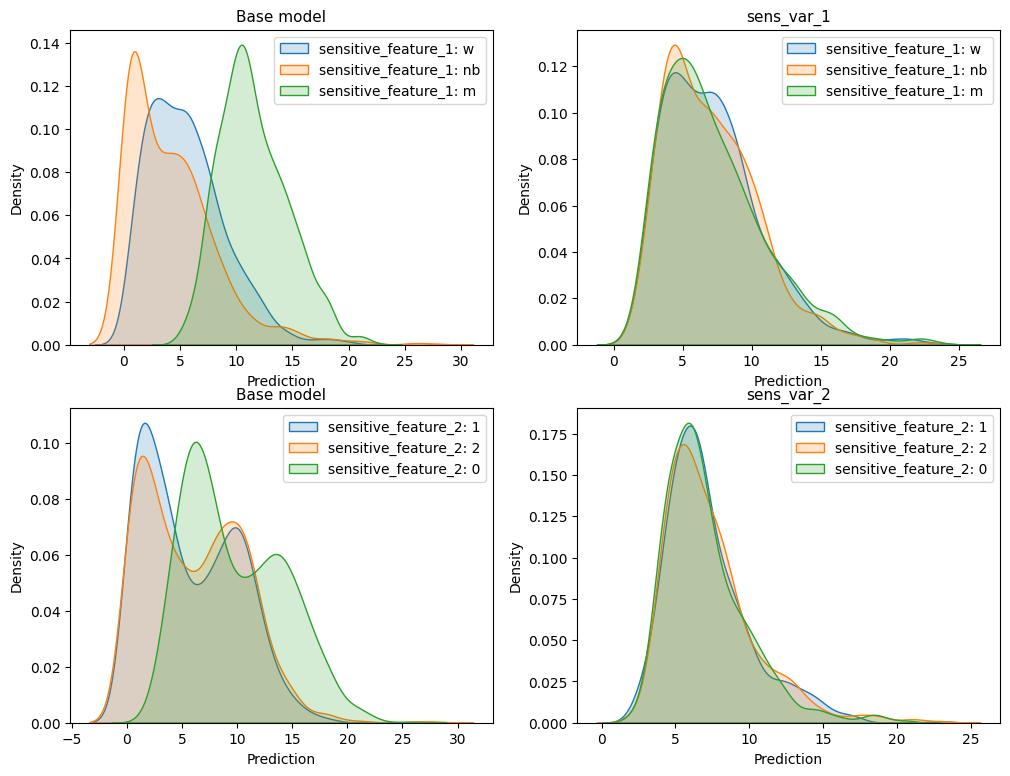

In [29]:
# Visualization of densities before and after exact fairness
viz_fairness_distrib(wst.y_fair_test, x_ssa_test)

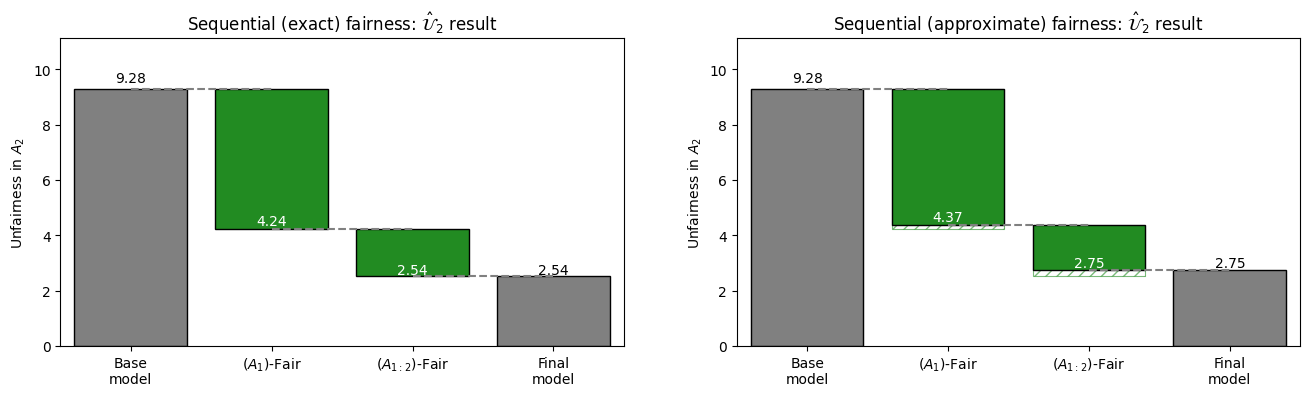

In [30]:
# Waterfall plot
unfs_list = [unfairness_multi(wst.get_sequential_fairness(), x_ssa_test), 
             unfairness_multi(approx_wst.get_sequential_fairness(), x_ssa_test)]

waterfall_plot(unfs_list)

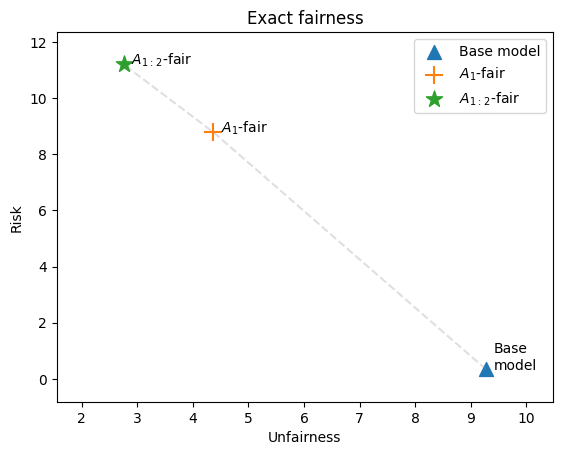

In [31]:
# Single arrow plot
arrow_plot(unfairness_multi(y_fair_dict, x_ssa_test), risk_multi(y_true, y_fair_dict))

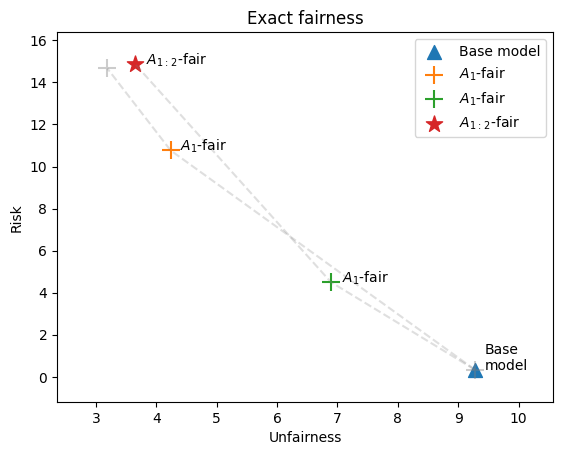

In [32]:
# Arrow plot for all permutations
unfs_list = unfairness_multi_permutations(calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test), 
                                          permutations_cols(x_ssa_test))
risk_list = risk_multi_permutations(y_true,
                                    calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test))

arrow_plot_permutations(unfs_list, risk_list)